In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 12)

In [125]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [126]:
mobile_sales.dtypes

DATE     datetime64[ns]
Sales           float64
dtype: object

In [127]:
mobile_sales.Sales.describe()

count      198.000000
mean     10842.757576
std       2605.006293
min        108.000000
25%       8856.000000
50%      10745.000000
75%      12399.750000
max      23740.000000
Name: Sales, dtype: float64

In [128]:
mobile_sales.describe()

,DATE,Sales
count,217,198.000000
mean,2009-12-31 04:25:26.267281152,10842.757576
min,2001-01-01 00:00:00,108.000000
25%,2005-07-01 00:00:00,8856.000000
50%,2010-01-01 00:00:00,10745.000000
75%,2014-07-01 00:00:00,12399.750000
max,2019-01-01 00:00:00,23740.000000
std,NaN,2605.006293


In [129]:
##Check if dates are missing
# Jan 2001 -jan 2019 (18 years 1 month == 217 month)

In [130]:
mobile_sales.set_index('DATE',inplace=True)

In [131]:
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


<Axes: xlabel='DATE'>

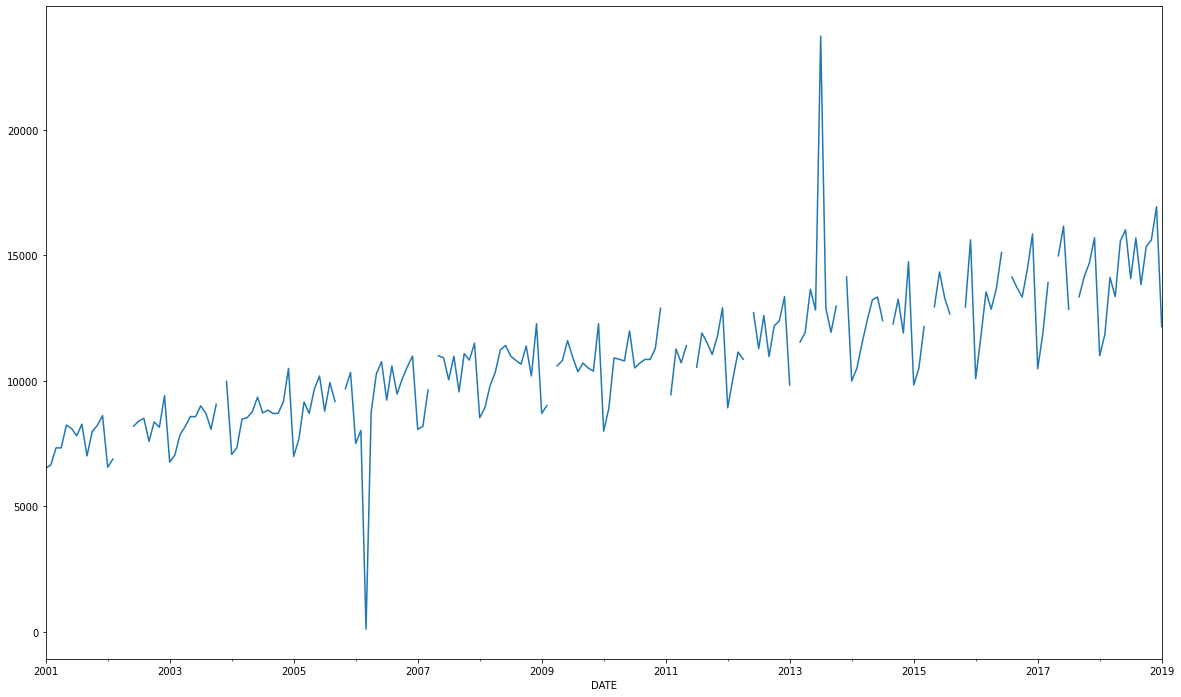

In [132]:
mobile_sales.Sales.plot()

### Handeling Missing Values

<Axes: xlabel='DATE'>

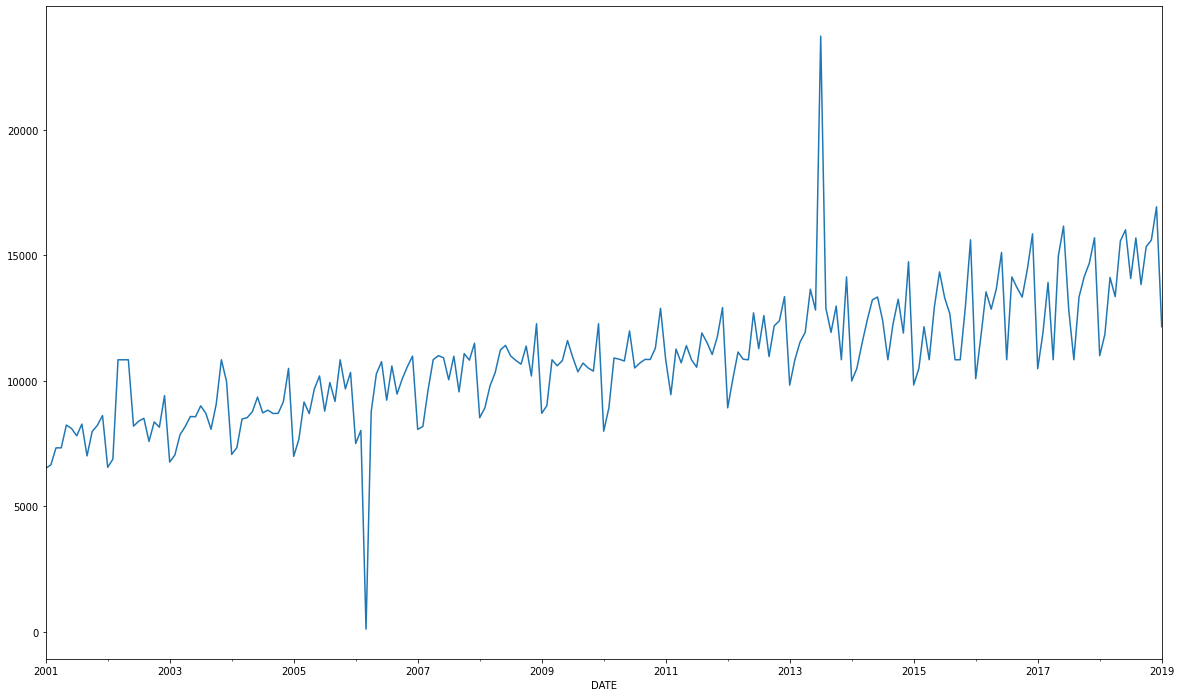

In [133]:
##filling NA with mean of entire data
mobile_sales.Sales.fillna(mobile_sales.Sales.mean()).plot(label="imputed")

<Axes: xlabel='DATE'>

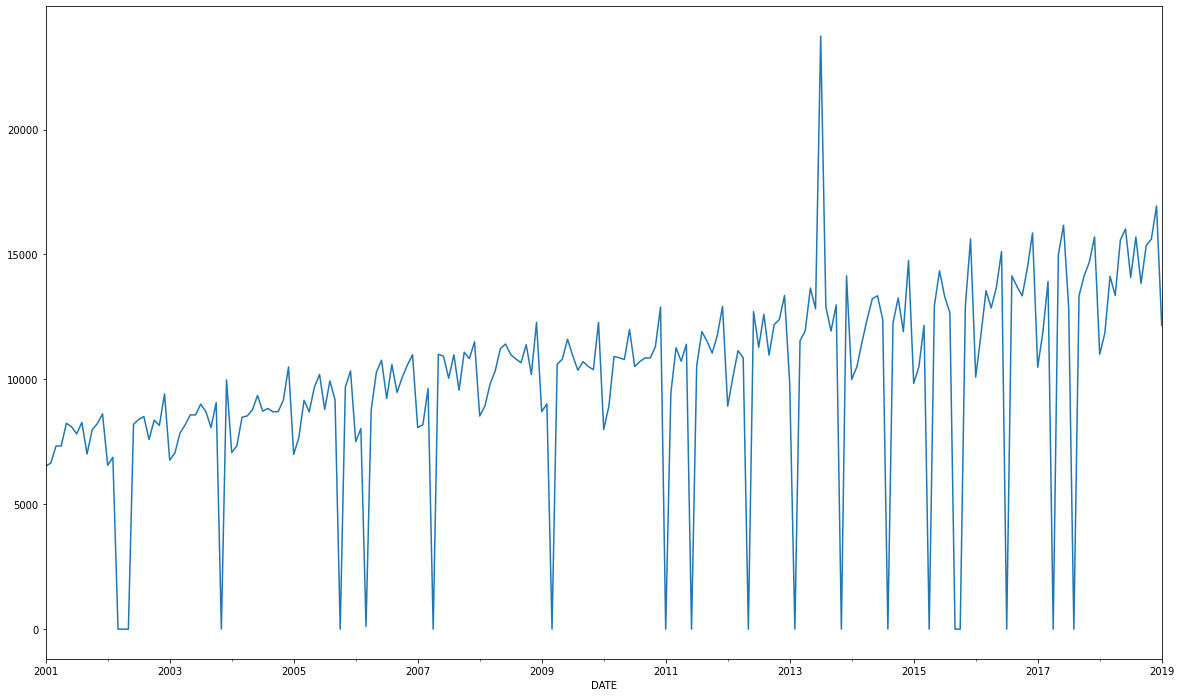

In [134]:
##filling NA with 0
mobile_sales.Sales.fillna(0).plot(label="imputed")

### Liner Interpolation

<Axes: xlabel='DATE'>

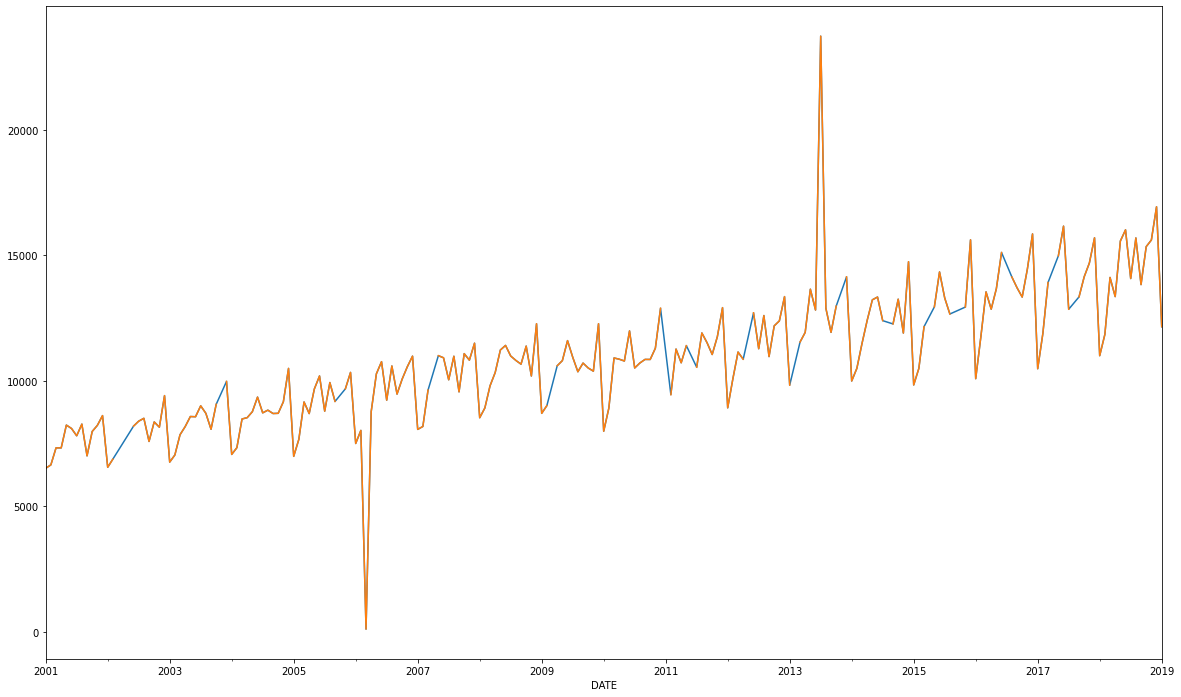

In [135]:
mobile_sales.Sales.interpolate(method="linear").plot(label='imputed linear int')
mobile_sales.Sales.plot(label='original')

In [136]:
mobile_sales.Sales=mobile_sales.Sales.interpolate(method="linear")

## Identifying and Removing Outliers

[]

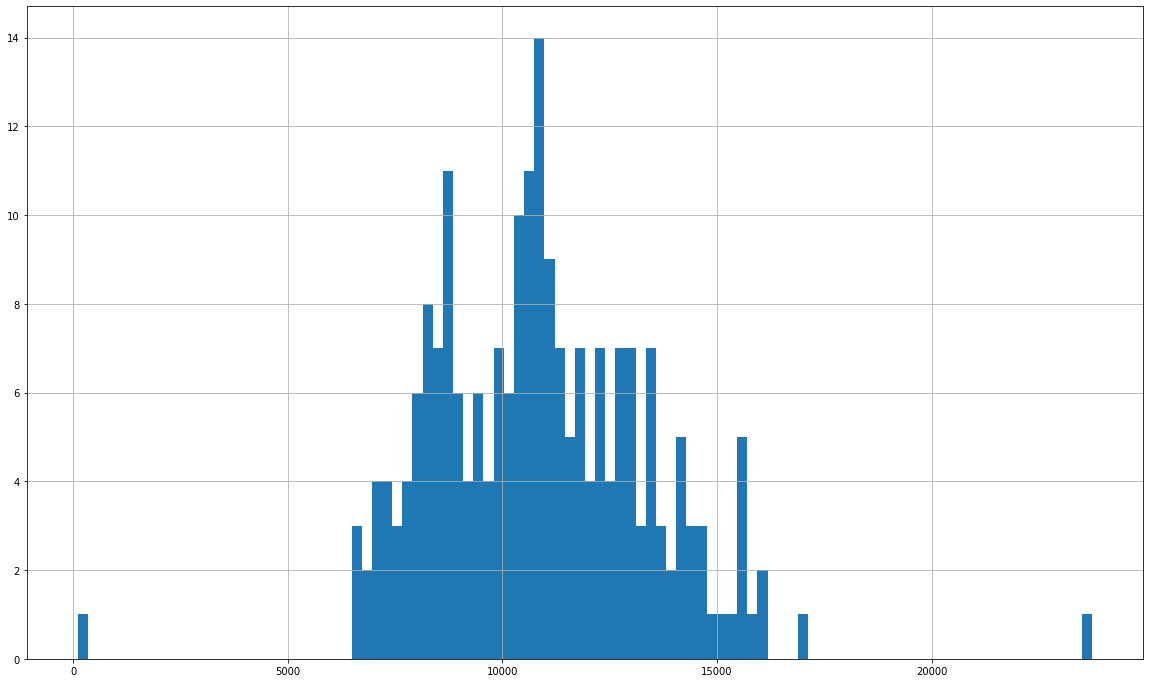

In [137]:

mobile_sales.Sales.hist(bins=100).plot()

In [138]:
mobile_sales.Sales.quantile(0.99)

16144.480000000001

In [139]:
mobile_sales.Sales.quantile(0.005)

6522.12

In [140]:
mobile_sales.Sales=mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.99),lower=mobile_sales.Sales.quantile(0.005))

<Axes: xlabel='DATE'>

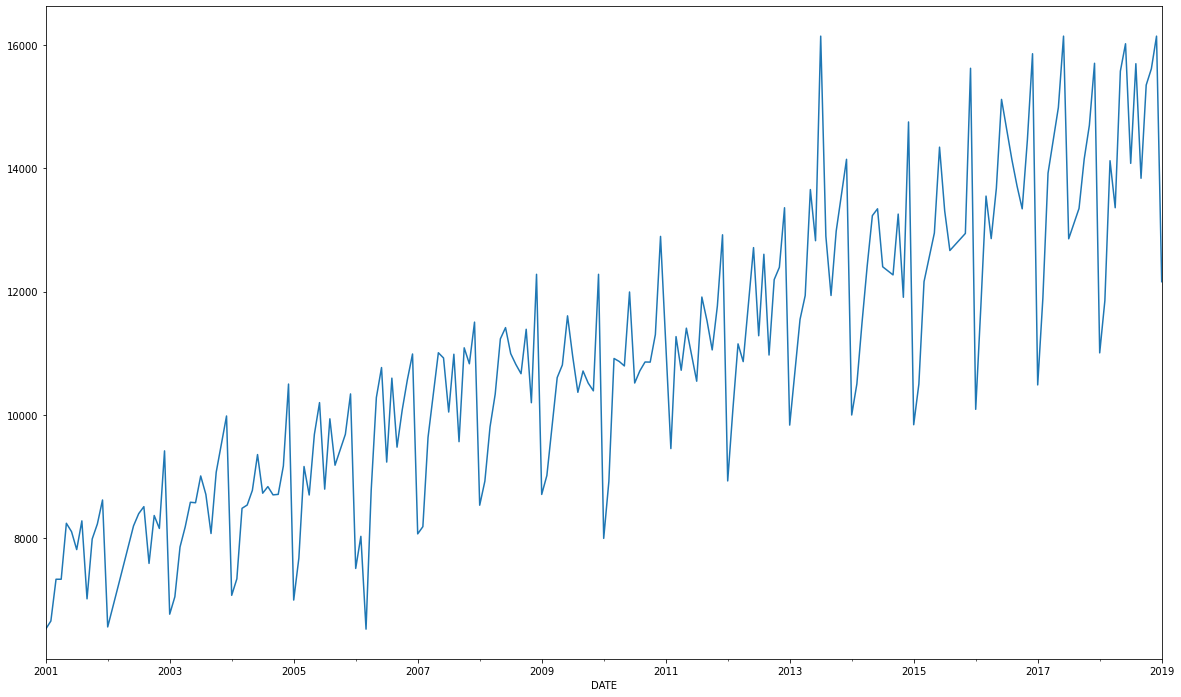

In [141]:
mobile_sales.Sales.plot()

### Moving Averages

<Axes: xlabel='DATE'>

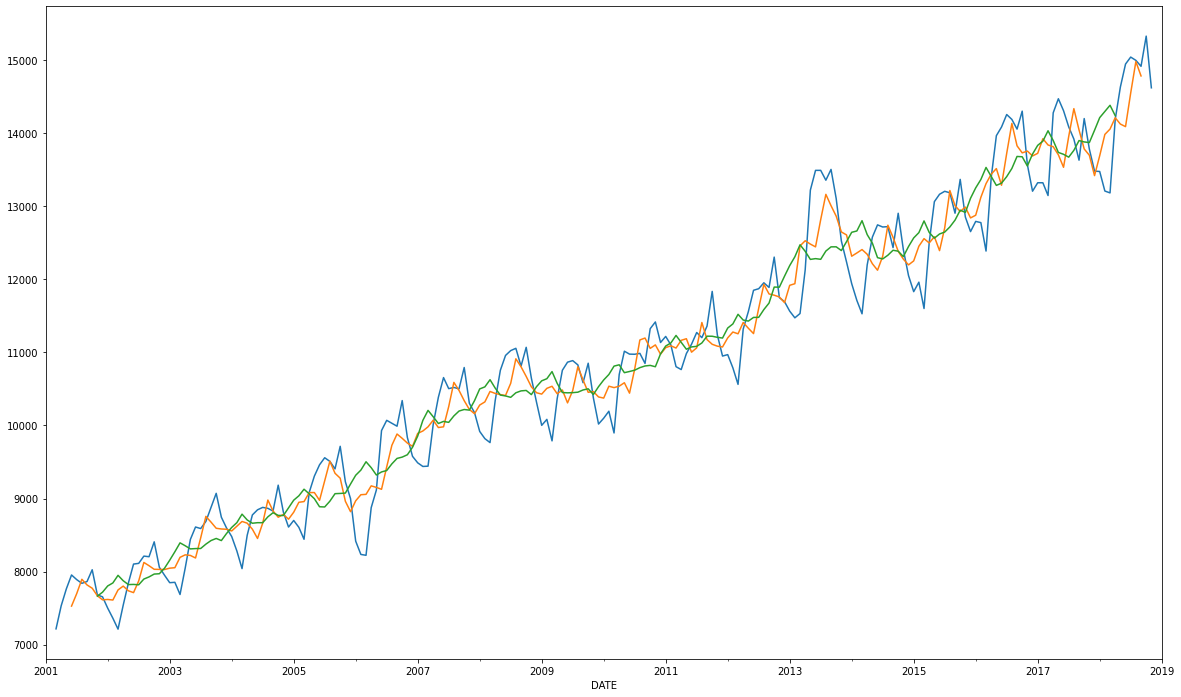

In [142]:

# mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(5,center=True).mean().plot(label="5")
mobile_sales.Sales.rolling(10,center=True).mean().plot(label="10")
mobile_sales.Sales.rolling(20,center=True).mean().plot(label="20")

<Axes: xlabel='DATE'>

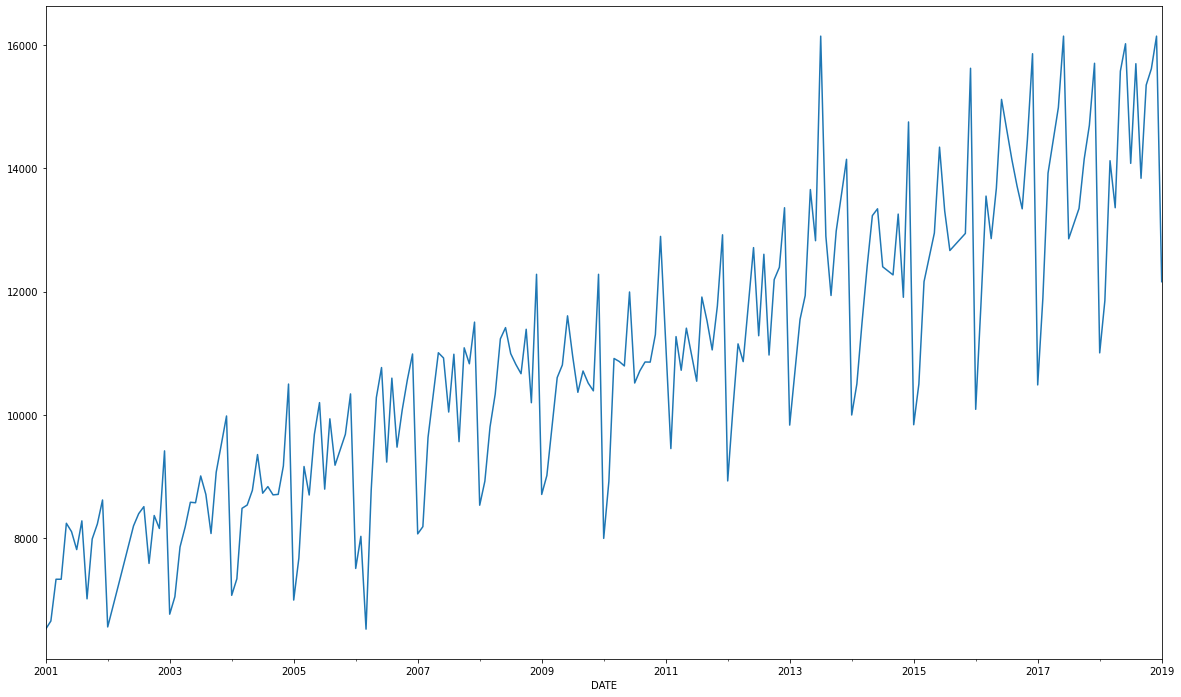

In [143]:
mobile_sales.Sales.plot(label="5")

###  TS decompositon 

In [144]:
import statsmodels.api as sm

In [145]:
model=sm.tsa.seasonal_decompose(mobile_sales.Sales,model='additive')

In [146]:
plt.rcParams['figure.figsize'] = (20, 10)

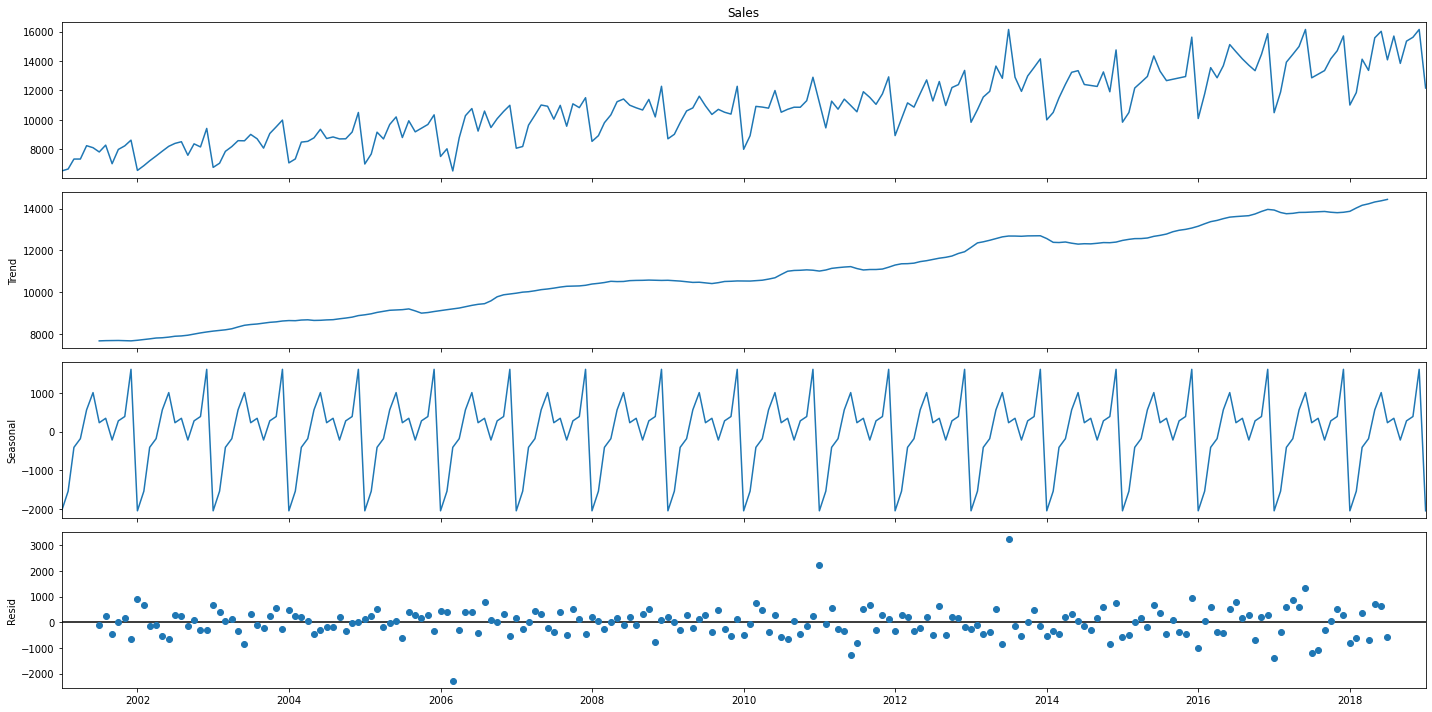

In [147]:
model.plot();

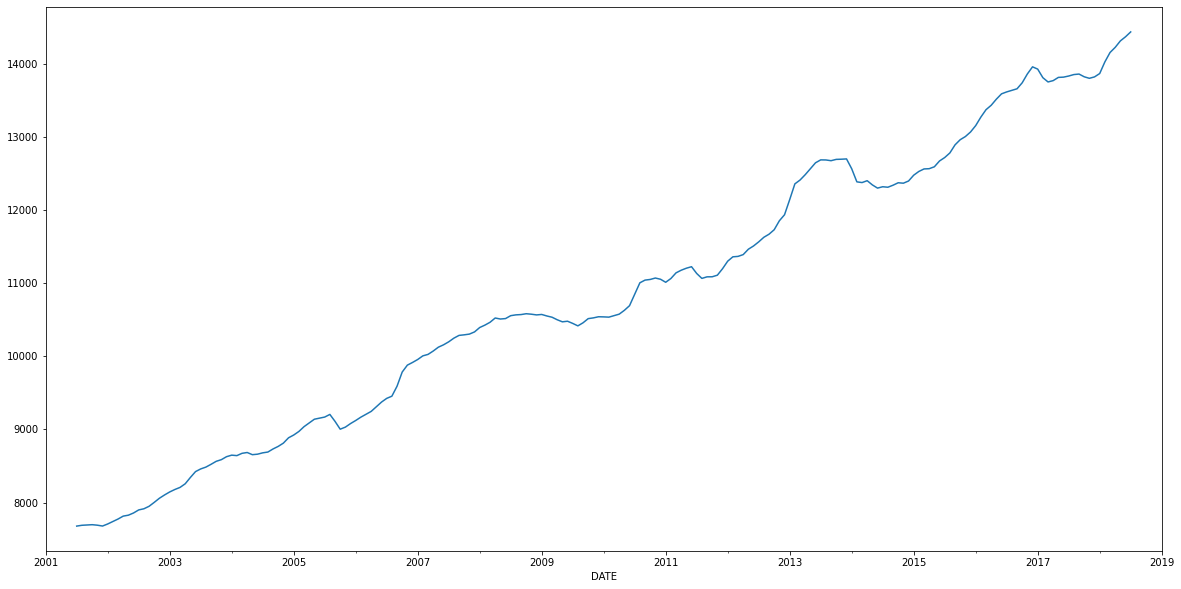

In [148]:
model.trend.plot();

#### See how increasing the window straighten the final MA

<Axes: xlabel='DATE'>

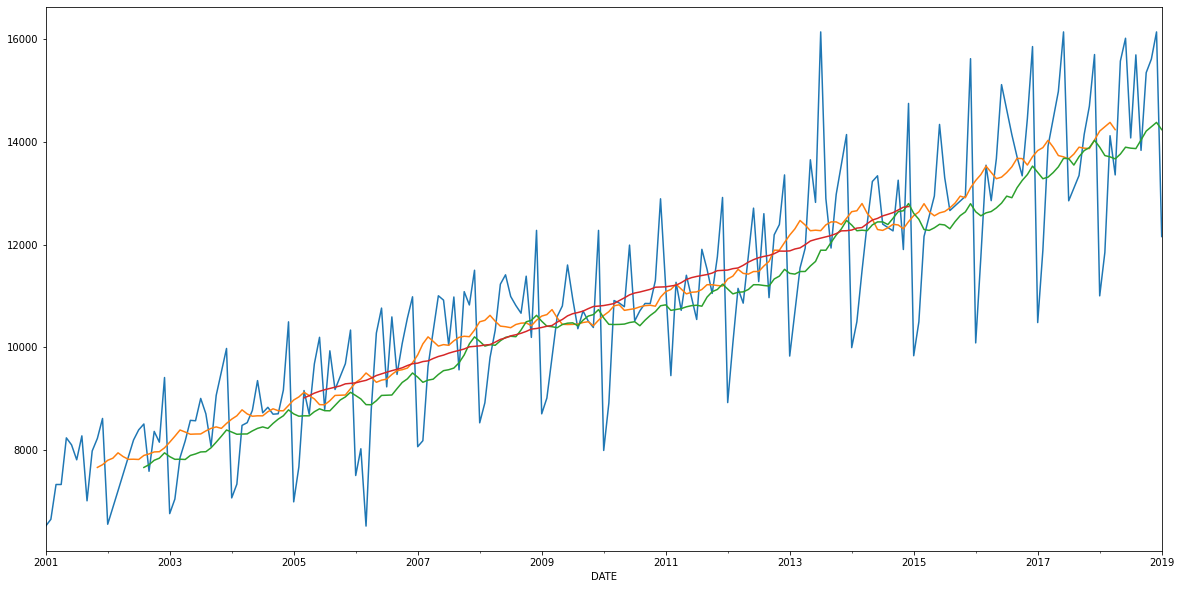

In [183]:
mobile_sales.Sales.plot(label="original")
# mobile_sales.Sales.rolling(5,center=True).mean().plot(label="5 MA")
# mobile_sales.Sales.rolling(10,center=True).mean().plot(label="10 MA")
mobile_sales.Sales.rolling(20,center=True).mean().plot(label="20 MA")
mobile_sales.Sales.rolling(20,center=False).mean().plot(label="20 MA One sided")
mobile_sales.Sales.rolling(100,center=True).mean().plot(label="100 MA")

#### Compare 12 MA with Decomposed Trend

<Axes: xlabel='DATE'>

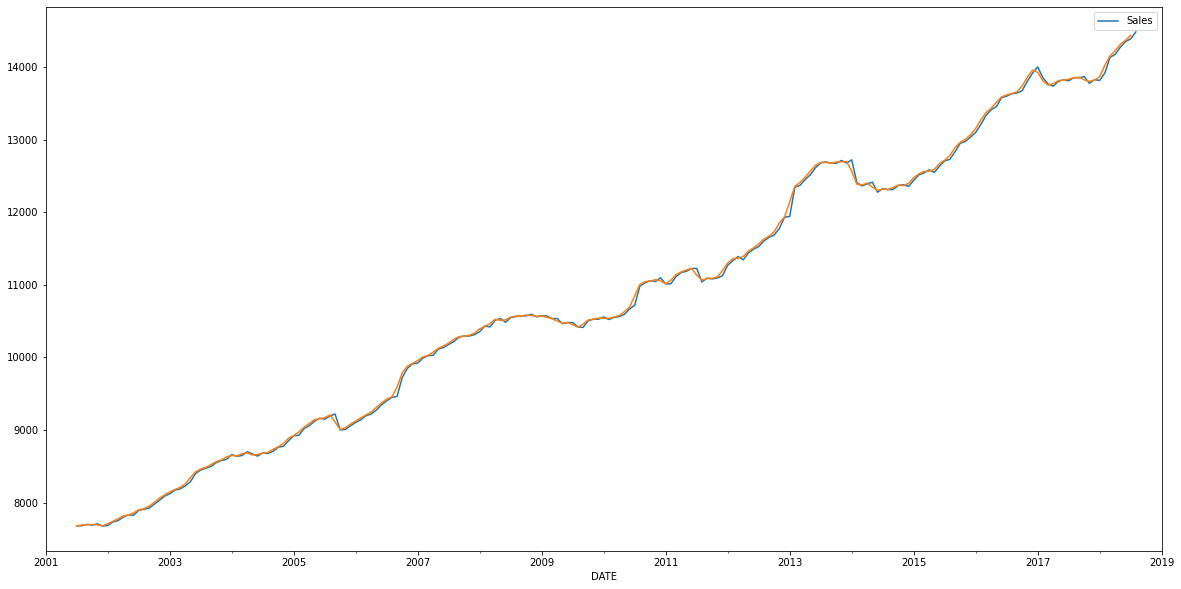

In [185]:
trend = mobile_sales.rolling(12, center=True).mean()
trend.plot()
model.trend.plot()

##### Remove Approx Trend From mobile sales
We get data without approx trend (this is mostly the Seasonality)
<br>PS: If you want to see the data in trend or detrend use head(15) as initial values would be null

<Axes: xlabel='DATE'>

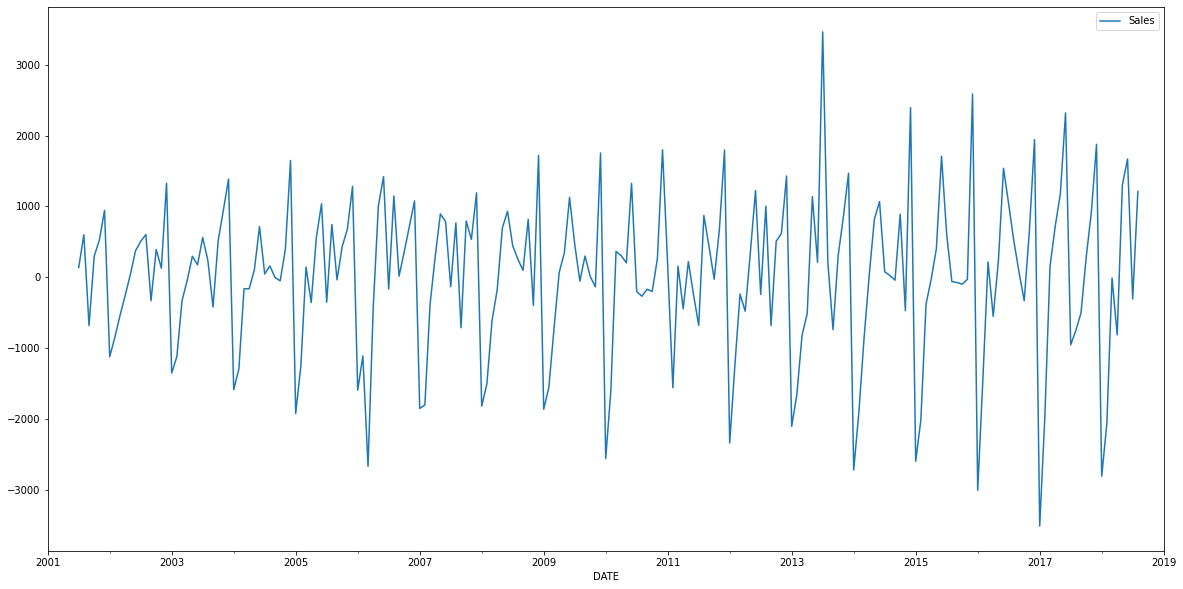

In [188]:
detrend=mobile_sales-trend
detrend.plot()

<Axes: xlabel='DATE'>

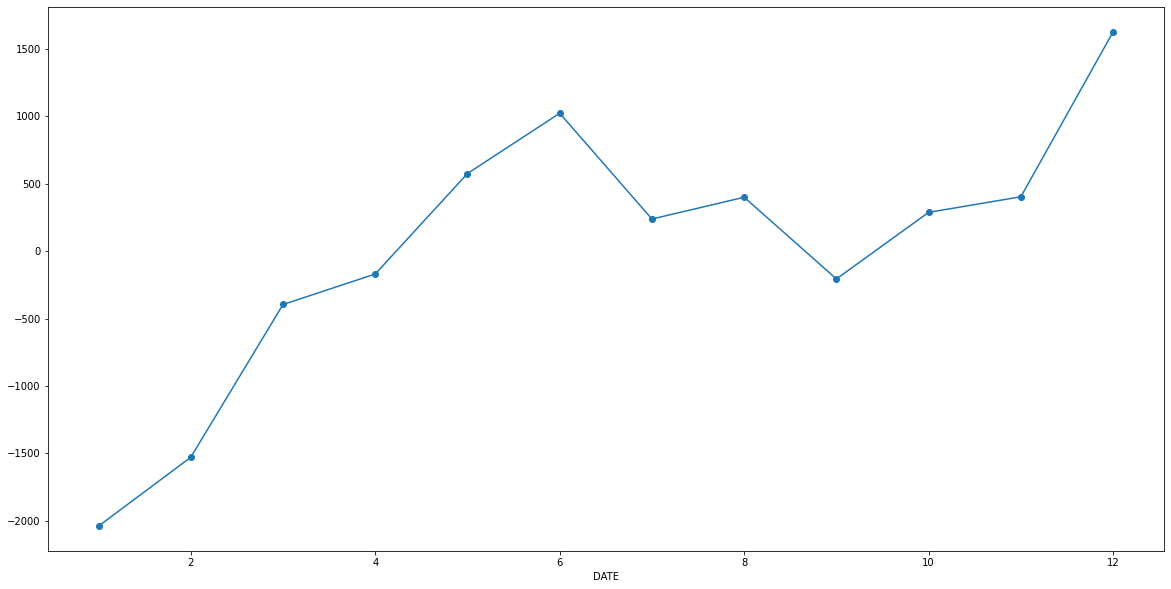

In [189]:
##Find Avg Seasonality for Every Month
dtf = detrend.reset_index()
dtf.groupby(dtf.DATE.dt.month)['Sales'].mean().plot(style='-o')

<Axes: xlabel='DATE'>

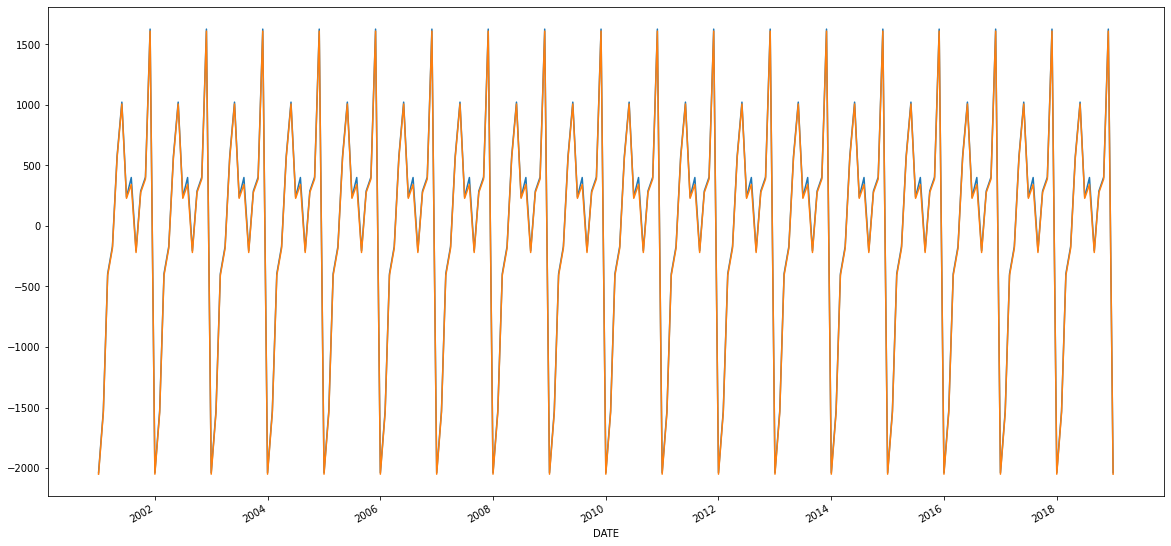

In [190]:
## Compare Model Seasonality decompose with Avg Seasonality
plt.plot(dtf.DATE, dtf.groupby(dtf.DATE.dt.month)['Sales'].transform('mean'))
model.seasonal.plot()

### Simple Forecasting Methods

In [191]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

In [156]:
### How do you measure accuracy/performance

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))


### Naive Approach

MAE : 3479.79
RMSE : 3757.483
MAPE: 0.232


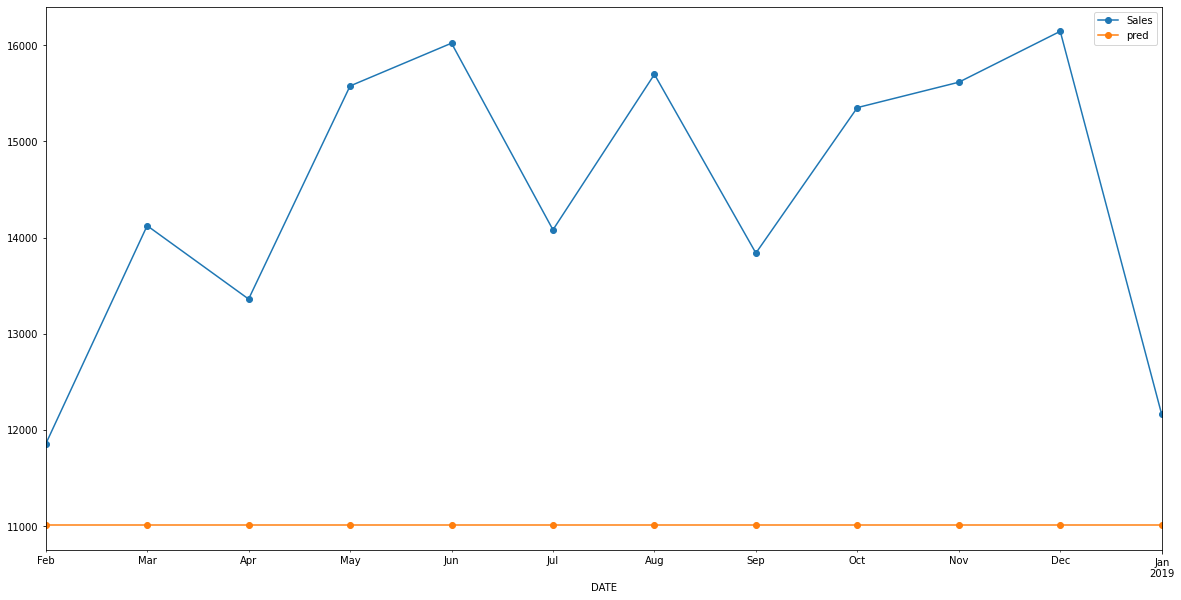

In [157]:
test_x['pred']=train_x['Sales'][-1]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Mean Approach

MAE : 3832.911
RMSE : 4086.679
MAPE: 0.257


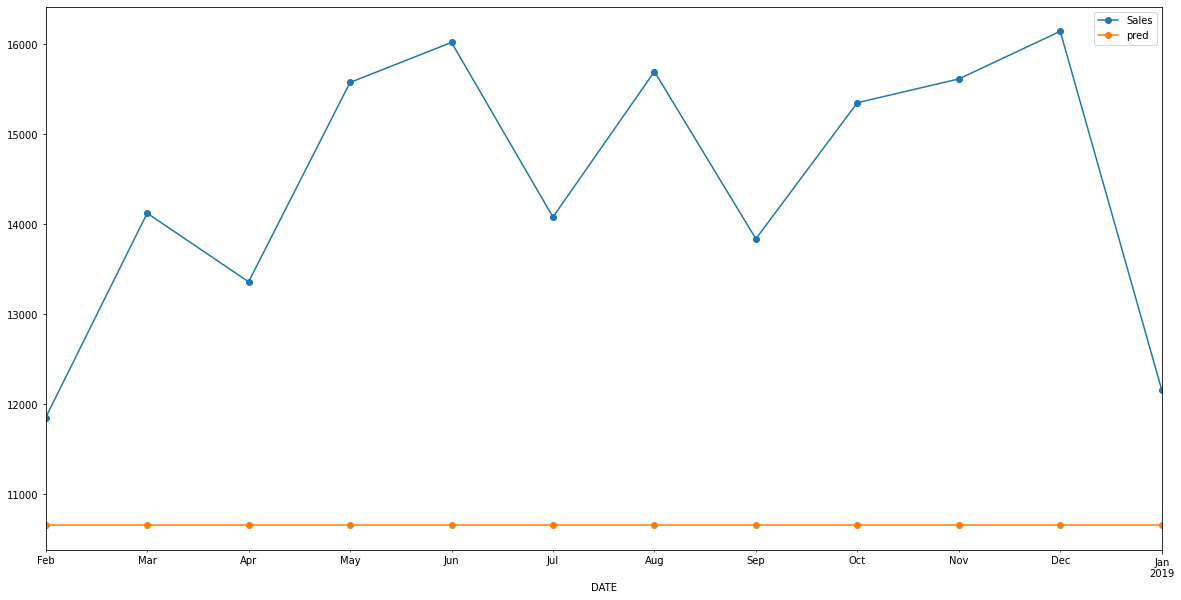

In [158]:
test_x['pred']=train_x['Sales'].mean()
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Seasonal Naive

In [159]:
test_x.index

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

MAE : 839.08
RMSE : 1075.542
MAPE: 0.058


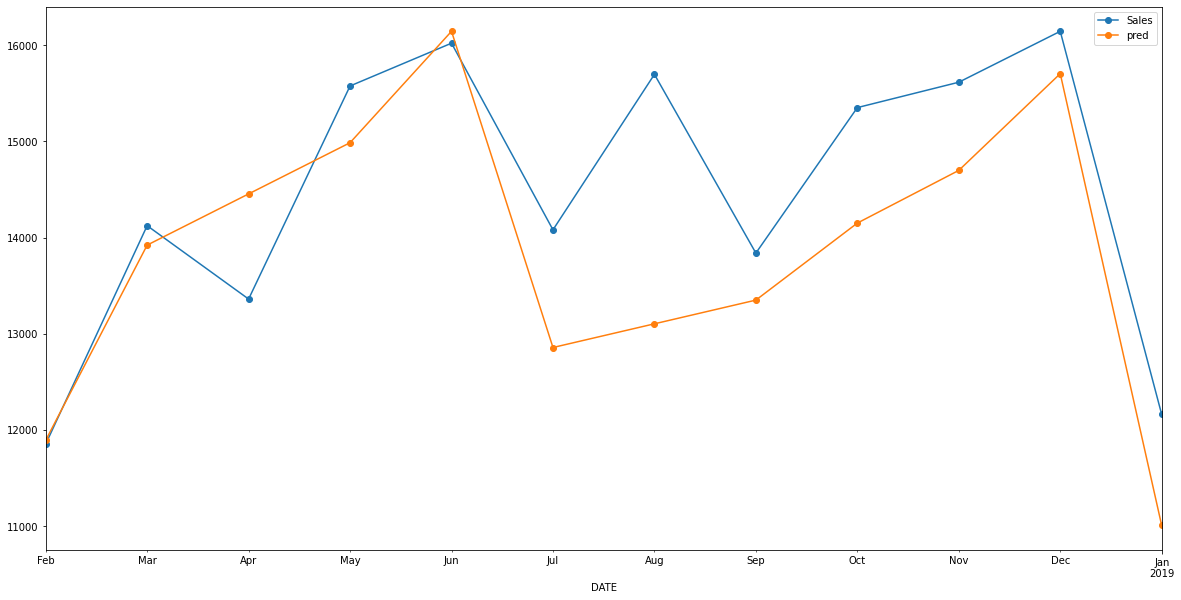

In [192]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

for i in test_x.index:
    test_x.loc[i,'pred'] = train_x.loc[(i - pd.DateOffset(years=1))]['Sales']

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Moving Average
We cant directly use the rolling function as it will give null values if just used on Training Data
<br> If you use all data (Mobile_Sales) then the output would be incorrect as we will then be using test data for training the model

In [193]:
### We need to create a new variable to store MA.
pred_ = train_x.Sales.copy().values
for i in range(12):
    pred_ = np.append(pred_, pred_[-3:].mean())
pd.Series(pred_)

0       6522.120000
1       6654.000000
2       7332.000000
3       7332.000000
4       8240.000000
           ...     
212    13184.042219
213    13175.059036
214    13195.613236
215    13184.904830
216    13185.192368
Length: 217, dtype: float64

MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


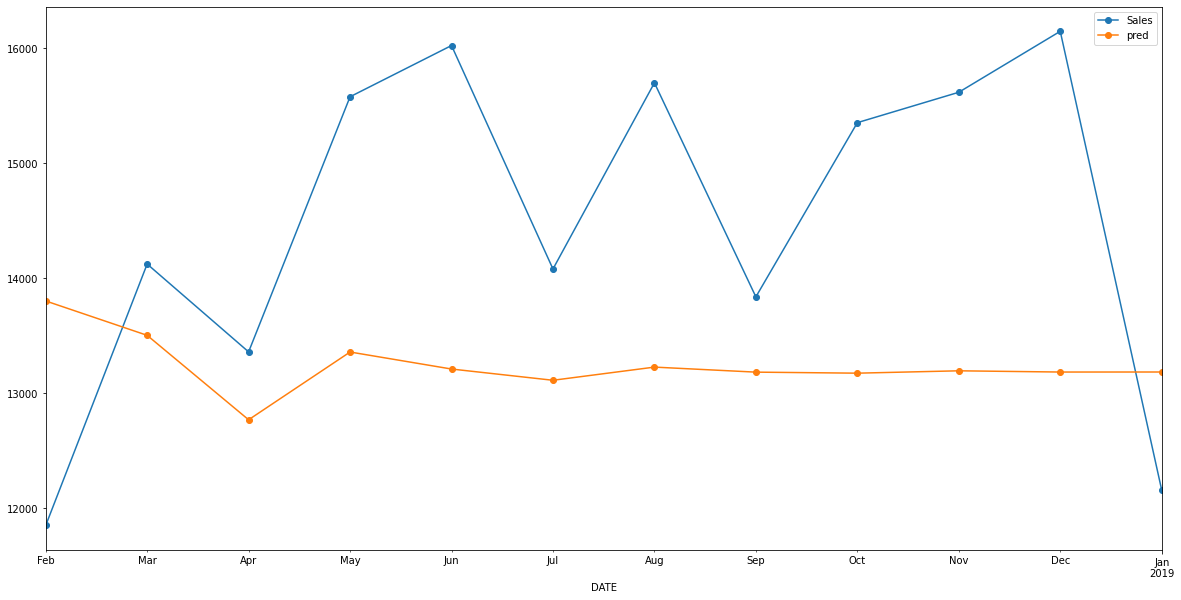

In [194]:
## take last 12 rows of the pred_ to find the predictions
test_x['pred'] = pred_[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Drift method

In [195]:
y_t=train_x['Sales'][-1]
y_0=train_x['Sales'][0]
slope= (y_t-y_0)/len(train_x['Sales'])
### Calculate the predicted values
for i in range(12):
    test_x.iloc[i]['pred']=slope*i + y_t

/var/folders/wc/7x5cjj6171gf3kyxlyncxf_c0000gn/T/ipykernel_27912/965450845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.iloc[i]['pred']=slope*i + y_t


MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


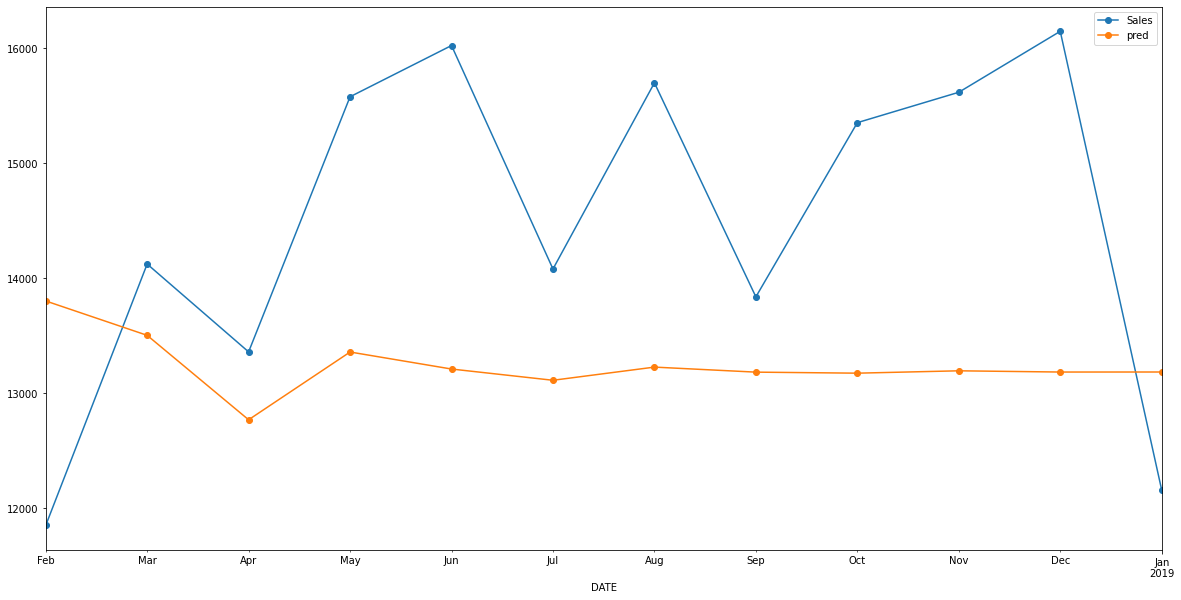

In [196]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### Smoothing Approaches
Will be recovered in the upcoming classes


#### SES

In [102]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales)
_ = model.fit(smoothing_level = 0.8)
_.fittedvalues

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


DATE
2001-01-01     6522.120000
2001-02-01     6522.120000
2001-03-01     6627.624000
2001-04-01     7191.124800
2001-05-01     7303.824960
                  ...     
2018-09-01    15444.233816
2018-10-01    14159.246763
2018-11-01    15112.649353
2018-12-01    15514.529871
2019-01-01    16018.489974
Length: 217, dtype: float64

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


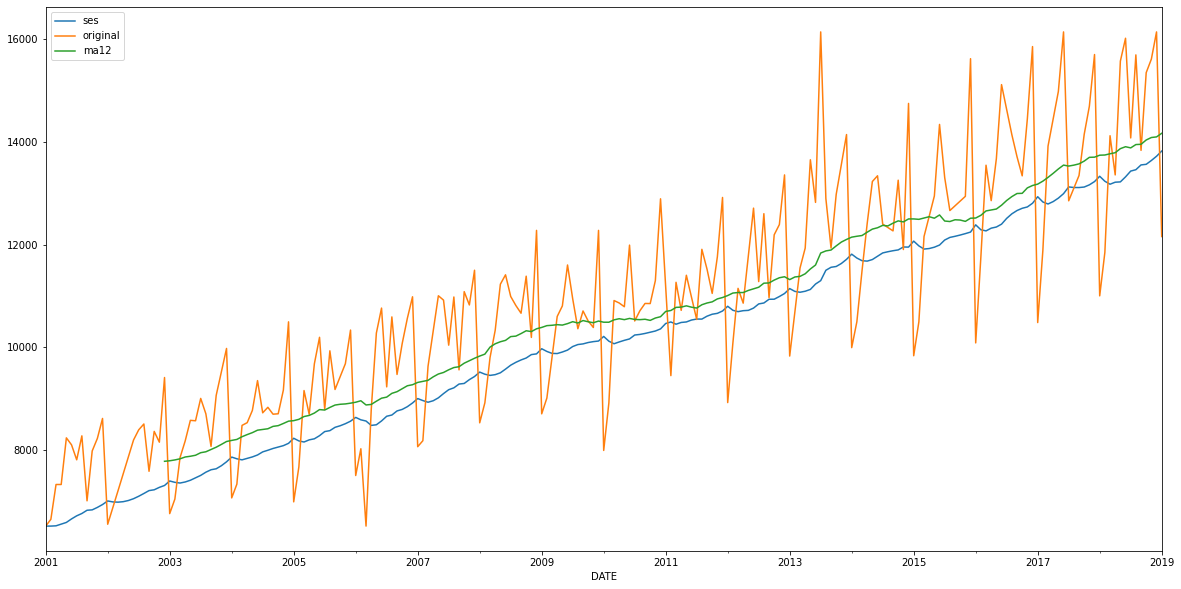

In [180]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)
pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(24).mean().plot(label='ma12')
plt.legend()